In [1]:
import logging
import platform
import sys
import os

TODO:
1) check value/vat/no vat --???
2) check headlines, fix it -- DONE


In [2]:
# !export GPN_DB_HOST=192.168.10.36
LIMIT = 5000

USE_CONTROL_SET = os.environ.get('GPN_USE_CONTROL_SET', '0') == '1'

In [3]:
try:
    LIMIT = int(LIMIT)
except:
    LIMIT = 5000
        
 
print(f'{LIMIT=}')



COLLECTION_NAME = 'documents'
# if USE_CONTROL_SET:
#     COLLECTION_NAME = 'documents_temp'
    
print(f'{COLLECTION_NAME=}')
print(f'{USE_CONTROL_SET=}')

LIMIT=5000
COLLECTION_NAME='documents'
USE_CONTROL_SET=False


In [4]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [5]:
# import tensorflow as tf

logger = logging.getLogger('export_ts')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

# print("tf",tf.__version__) 



DEBUG - 2023-04-22 10:42:18,594 - export_ts - --=logging started=--


In [6]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.4.14
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [7]:
%matplotlib inline

#3rd party--------
import json
import re
import pandas as pd
import numpy as np

from pandas import DataFrame
from pathlib import Path

from datetime import datetime
from datetime import date

from math import log1p
from pandas import DataFrame


from pathlib import Path

from bson import ObjectId
from bson import json_util


from dateutil.relativedelta import relativedelta

from pymongo import ASCENDING
 

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from collections import Counter



#ours---------

 
from analyser.persistence import DbJsonDoc
from analyser.structures import DocumentState
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph, embedd_tokens
from analyser.ml_tools import SemanticTag
from analyser.headers_detector import get_tokens_features

from integration.db import get_mongodb_connection
from integration.word_document_parser import join_paragraphs

from colab_support.renderer import plot_embedding

from tf_support.embedder_elmo import ElmoEmbedder
from tf_support.super_contract_model import get_semantic_map_new, t_semantic_map_keys_price
from tf_support.super_contract_model import semantic_map_keys_contract, t_semantic_map_keys_common, t_semantic_map_keys_org

from trainsets.retrain_contract_uber_model import save_contract_data_arrays



2023-04-22 10:42:19.627428: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[documents.py:271 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[tools.py:28 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


In [8]:
def get_doc_from_db_by_id (objid):
    db = get_mongodb_connection()
    documents_collection = db[COLLECTION_NAME]
    _id = ObjectId(str(objid))
    jdata = documents_collection.find_one({'_id': _id})
    return jdata
    # return DbJsonDoc(jdata)





### Init ml flow

In [9]:
import mlflow
 
ml_flow_url = os.environ.get('MLFLOW_URL', "http://192.168.10.38:5000")
mlflow.set_tracking_uri(ml_flow_url)
print(f'{ml_flow_url=}', 'set MLFLOW_URL env var to re-define')
mlflow.set_experiment("Анализатор: экспорт данных из mongo")
             

ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define


<Experiment: artifact_location='mlflow-artifacts:/273381584422389923', creation_time=1680874514048, experiment_id='273381584422389923', last_update_time=1681801947445, lifecycle_stage='active', name='Анализатор: экспорт данных из mongo', tags={}>

### Prepare workdir

In [10]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'


assert os.path.isdir(analyser.hyperparams.work_dir)

In [11]:


NOTEBOOKS_DIR = str(Path(analyser.__file__).parent.parent/'trainsets')
print(f'{LIMIT=}')
print(f'{NOTEBOOKS_DIR=}')
print(f'{analyser.hyperparams.work_dir=}', )
print(f'{reports_path=}', )

LIMIT=5000
NOTEBOOKS_DIR='/root/artem/analyser/trainsets'
analyser.hyperparams.work_dir=PosixPath('/root/artem/work')
reports_path=PosixPath('/root/artem/analyser/training_reports')


### Query DB for contact IDs

#### Load meta data CSV

In [13]:
contract_trainset_meta_fn = 'contract_trainset_meta.temp.csv'
if USE_CONTROL_SET:
    contract_trainset_meta_fn = 'contract_trainset_meta.control.temp.csv'
    
export_fn = str(Path(work_dir) / contract_trainset_meta_fn)
export_fn

'/root/artem/work/contract_trainset_meta.temp.csv'

In [14]:
!touch {export_fn}
# !tail {export_fn}

In [15]:


# stats = pd.read_csv(export_fn, index_col=0)
mlflow.log_param('metafile',  export_fn)

try:
    stats = pd.read_csv(export_fn, index_col=0)

    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
    mlflow.log_param('last_doc_export_date',  lastdate)
    mlflow.log_metric('docs_in_metafile_start',  len(stats))
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    # stats = stats.astype({'currency':str})
    stats['currency']=''
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'


lastdate=2023-04-20 16:13:29.529000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


In [16]:
 
display(Markdown(f"#### {lastdate:%d.%m.%Y} -- дата последнего экспортированного документа"))


#### 20.04.2023 -- дата последнего экспортированного документа

In [17]:
stats

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos
5de8a3fc1b3453848224a9c6,RUB,db,e898024cc7bc22f84e536233a3582d13,2.0.0,CONTRACT,2023-04-20 17:19:49.728792,1758.0,2020-07-02 14:54:46.055000+00:00,11.0,5.000000e+03,...,Акционерное общество,Армавирский учебно-технический центр агропромы...,Исполнитель,Государственное автономное учреждение,Service,0.000000,46.0,2020-06-12 06:35:50.072000+00:00,True,NaN
5de8a3fd1b3453848224a9d6,RUB,db,2cd1cd37e48f82814783a2574ada04cb,2.0.0,CONTRACT,2023-04-20 17:19:49.736269,2484.0,2020-07-04 09:52:36.582000+00:00,17.0,3.538358e+04,...,Акционерное общество,Аргус,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,0.996766,47.0,2020-06-12 12:39:01.410000+00:00,True,NaN
5deba9034ddc27bcf92dd383,RUB,db,7e9e0a5f729f876a5b3055de5076db9d,1.10.0,CONTRACT,2023-04-20 17:19:49.741718,2395.0,2020-06-10 19:38:02.517000+00:00,6.0,6.000000e+07,...,Общество с ограниченной ответственностью,Нептун,Залогодержатель,Общество с ограниченной ответственностью,PledgeEncumbrance,0.000000,58.0,2020-06-09 00:45:55.207000+00:00,True,NaN
5dece9b84ddc27bcf92dd408,RUB,db,6cf925262f97d4a7be10f9e91b2d60fa,1.22.1,CONTRACT,2023-04-20 17:19:49.750009,3153.0,2020-06-30 19:22:54.901000+00:00,12.0,1.836000e+05,...,Общество с ограниченной ответственностью,ЭКРУСС,Арендодатель,Общество с ограниченной ответственностью,Renting,0.333537,44.0,NaT,True,NaN
5dece9b94ddc27bcf92dd409,NaN,db,1e7c8c639d6f59057a47c43f3ccb5ac4,1.22.1,CONTRACT,2023-04-20 17:19:49.756279,2763.0,2020-06-30 19:23:21.413000+00:00,14.0,NaN,...,Общество с ограниченной ответственностью,Газпром нефть,Агент,Публичное акционерное общество,AgencyContract,0.000000,26.0,2020-06-16 11:22:15.339000+00:00,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64413a42c083816b32b0c73b,NaN,db,698cc95dcc0550ee63245912e0e004b4,23.3.11,CONTRACT,2023-04-20 17:20:49.874777,1547.0,2023-04-20 16:12:54.865000+00:00,11.0,1.500000e+11,...,Публичное акционерное общество,Снабжение,Заемщик,Общество с ограниченной ответственностью,Loans,1.000000,101.0,2023-04-20 13:19:13.988000+00:00,True,136.0
64413a4cc083816b32b0c73e,RUB,db,b2cbccb013682940b58680646457f40c,23.3.11,CONTRACT,2023-04-20 17:20:49.880902,946.0,2023-04-20 16:12:55.662000+00:00,12.0,3.450000e+10,...,Публичное акционерное общество,ПЛАНЕТА,Заемщик,Общество с ограниченной ответственностью,Loans,1.000000,31.0,2023-04-20 13:20:12.482000+00:00,True,103.0
64413a59c083816b32b0c740,RUB,db,f971243d4e38155058e187759c1db2c2,23.3.11,CONTRACT,2023-04-20 17:20:49.886596,1452.0,2023-04-20 16:13:27.470000+00:00,10.0,1.500000e+08,...,Публичное акционерное общество,ЦИП,NaN,Общество с ограниченной ответственностью,Loans,0.979717,85.0,NaT,True,NaN
64413a63c083816b32b0c743,RUB,db,6efa4d082c760d62381250d53bc9dea4,23.3.11,CONTRACT,2023-04-20 17:20:49.890997,917.0,2023-04-20 16:13:28.293000+00:00,14.0,3.450000e+11,...,Акционерное общество,Октябрь,Займодавец,Публичное акционерное общество,Loans,1.000000,31.0,2023-04-20 13:21:27.076000+00:00,True,110.0


# functions

In [18]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  stats.at[_id, 'value'] = None
  stats.at[_id, 'value_log1p'] = None
  stats.at[_id, 'value_span'] = None
  stats.at[_id, 'currency'] = None
    
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
    
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      if _orgs[0]:
          stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
          stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')
          stats.at[_id, 'org-1-type'] = _orgs[0].get('type', {}).get('value')

      if len(_orgs)>1:
          if _orgs[1]:
            stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
            stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')
            stats.at[_id, 'org-2-type'] = _orgs[1].get('type', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  stats.at[_id, 'user_correction_date'] = None
  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)

    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in d.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


# d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
# jd = DbJsonDoc(d)
# add_stats_record(jd, stats)
# stats.loc['5fe34f62b770574a005553be']

# load legacy json

In [19]:
_DEBUG = False

if not USE_CONTROL_SET:

    file_data=None

    try:
        fn = work_dir / 'documents.json'
        with open(fn) as file:
            file_data = json.load(file, object_hook=json_util.object_hook)

            print(f'total docs in {fn} is {len(file_data)}')    
  
    except Exception as ex:
        logger.exception(ex)    

    if _DEBUG:
        a_doc_from_json=DbJsonDoc(file_data[3])

        print(a_doc_from_json.get_attributes_tree())
        print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622


In [20]:

# TODO: import!!!



print("semantic_map_keys_contract", semantic_map_keys_contract)

 

if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:150], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


In [21]:
_DEBUG

False

In [22]:
#test one
from analyser.headers_detector import get_tokens_features

if _DEBUG:
    d = get_doc_from_db_by_id(ObjectId('636dfd1473925c8dae26f910'))
    if d is not None:
        jd = DbJsonDoc(d)
        semantic_map: DataFrame = get_semantic_map_new(jd)

        tokens_features = get_tokens_features(jd.get_tokens_map_unchaged().tokens)

        plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')
        plot_embedding(tokens_features, f'tokens')

In [23]:
# tokens_features

### Adding data from old json file to the stats table

In [24]:
# fff
files_dict = {}
files_cnt = 0

if not USE_CONTROL_SET:
    
    if file_data:
        k=0
        for d in file_data:
            k+=1 
            jd = DbJsonDoc(d)
        #     print( jd.analysis['analyze_timestamp'])
            files_dict[jd.get_id()] = jd
            try:            
                add_stats_record(jd, stats, source = 'file')
                files_cnt+=1
            except Exception as e:
                print(e)
                print(jd.get_id())
    #             raise (e)

            if k % 100 == 0:

                print(f'{k} of {len(file_data)}')
                stats.to_csv(export_fn, index=True)
                print(f'stats saved to {export_fn}')


    mlflow.log_param('files_in_json',  files_cnt)            
    stats.to_csv(export_fn, index=True)
 


print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-1-type,org-2-name,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos
5de8a3fc1b3453848224a9c6,RUB,file,e898024cc7bc22f84e536233a3582d13,2.0.0,CONTRACT,2023-04-22 10:44:01.331348,1758.0,2020-07-02 14:54:46.055000+00:00,11.0,5000.00,...,Акционерное общество,Армавирский учебно-технический центр агропромы...,Исполнитель,Государственное автономное учреждение,Service,0.000000,46.0,2020-06-12 06:35:50.072000+00:00,True,NaN
5de8a3fd1b3453848224a9d6,RUB,file,2cd1cd37e48f82814783a2574ada04cb,2.0.0,CONTRACT,2023-04-22 10:44:01.339317,2484.0,2020-07-04 09:52:36.582000+00:00,17.0,35383.58,...,Акционерное общество,Аргус,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,0.996766,47.0,2020-06-12 12:39:01.410000+00:00,True,NaN
5deba9034ddc27bcf92dd383,RUB,file,7e9e0a5f729f876a5b3055de5076db9d,1.10.0,CONTRACT,2023-04-22 10:44:01.346090,2395.0,2020-06-10 19:38:02.517000+00:00,6.0,60000000.00,...,Общество с ограниченной ответственностью,Нептун,Залогодержатель,Общество с ограниченной ответственностью,PledgeEncumbrance,0.000000,58.0,2020-06-09 00:45:55.207000+00:00,True,NaN
5dece9b84ddc27bcf92dd408,RUB,file,6cf925262f97d4a7be10f9e91b2d60fa,1.22.1,CONTRACT,2023-04-22 10:44:01.355033,3153.0,2020-06-30 19:22:54.901000+00:00,12.0,183600.00,...,Общество с ограниченной ответственностью,ЭКРУСС,Арендодатель,Общество с ограниченной ответственностью,Renting,0.333537,44.0,NaT,True,NaN
5dece9b94ddc27bcf92dd409,None,file,1e7c8c639d6f59057a47c43f3ccb5ac4,1.22.1,CONTRACT,2023-04-22 10:44:01.362882,2763.0,2020-06-30 19:23:21.413000+00:00,14.0,NaN,...,Общество с ограниченной ответственностью,Газпром нефть,Агент,Публичное акционерное общество,AgencyContract,0.000000,26.0,2020-06-16 11:22:15.339000+00:00,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,None,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,CONTRACT,2023-04-22 10:44:11.085440,7298.0,2020-06-12 22:43:06.038000+00:00,4.0,NaN,...,NaN,NaN,NaN,NaN,None,NaN,0.0,2020-06-11 08:49:53.635000+00:00,False,NaN
5efe9252777d4b67a92d5621,RUB,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,CONTRACT,2023-04-22 10:44:20.277147,19504.0,2020-07-03 16:50:25.668000+00:00,26.0,65300168.00,...,Общество с ограниченной ответственностью,Шлюмберже Лоджелко Инк.,Исполнитель,None,None,NaN,0.0,NaT,False,NaN
5efe9280777d4b67a92d56ce,None,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,CONTRACT,2023-04-22 10:44:21.568596,14025.0,2020-07-03 21:47:22.279000+00:00,2.0,NaN,...,NaN,NaN,NaN,NaN,None,NaN,0.0,NaT,False,NaN
5efe9288777d4b67a92d56d3,None,file,33f326573547c95e1d381eecd79136a2,2.0.0,CONTRACT,2023-04-22 10:44:21.919732,19219.0,2020-07-03 21:15:51.170000+00:00,25.0,NaN,...,Общество с ограниченной ответственностью,Газпромнефть-Сахалин,Исполнитель,Общество с ограниченной ответственностью,None,NaN,0.0,NaT,False,NaN


In [30]:
 
# lastdate = 
_df_from_db = stats[stats.source == 'db']
_df_valid = _df_from_db[_df_from_db.valid==True]
lastdate = _df_valid[["user_correction_date", 'analyze_date']].max().max()

Timestamp('2023-04-20 16:13:29.529000+0000', tz='UTC')

In [31]:
if not USE_CONTROL_SET:
    invalid = stats[stats['valid']==False]
    print(f'{len(invalid)}: number of invalid records')
    mlflow.log_metric('invalid records',  len(invalid))     
    invalid

368: number of invalid records


# Fetch fresh docs from Mongo DB

In [32]:
#last known doc edit date minus 2 week

lastdate  += relativedelta(days=-15)  
lastdate

Timestamp('2023-04-05 16:13:29.529000+0000', tz='UTC')

In [ ]:
report_date = datetime.now() + relativedelta(days=-2)  
report_date

In [33]:
q_contract_like = {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  } 
q_human_done = {"user.attributes_tree": {"$ne": None}}    

query = {
  '$and': [
    q_contract_like,

    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          q_human_done
        ]},

    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}


# if USE_CONTROL_SET:
#     query = {
#       '$and': [
#         q_contract_like,
#         { 'subset': 'CONTROL_TRAIN'},
 
#         {'$or': [
#               {"analysis.attributes_tree": {"$ne": None}},
#               q_human_done
#             ]},
 
#         {'$or': [
#           {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
#           {'user.updateDate': {'$gt': lastdate}}
#         ]}
#       ]
#     }
    
    
# else:
#     query = {
#       '$and': [
#         q_contract_like,
#         { 'subset': {"$ne": 'CONTROL_TEST'} },
 
#         {'$or': [
#               {"analysis.attributes_tree": {"$ne": None}},
#               q_human_done
#             ]},
 
#         {'$or': [
#           {'analysis.analyze_timestamp': {'$gt': lastdate}}, 
#           {'user.updateDate': {'$gt': lastdate}}
#         ]}
#       ]
#     }

db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True, 
                                           'analysis.checksum':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(LIMIT)

res = list([i for i in res])
mlflow.log_metric('fresh_docs_in_db',  len(res))     
# print(res[0])
_s = f"#### {len(res)} -- всего проанализировано/размечено новых документов после {lastdate:%d.%m.%Y}"
display(Markdown(_s))

res[:1]

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

DB HOST IS: 192.168.10.36


#### 958 -- всего проанализировано/размечено новых документов после 05.04.2023

[{'_id': ObjectId('5ec2b8db665f7603e03b1282'),
  'analysis': {'checksum': -6155744448520320908},
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 4, 18, 13, 51, 19, 103000)}}]

## Fetch controls set

In [45]:
stats['subset'] = 'unknown'
q_state = {"state":{ '$in': [15, 12] }  } 
query = {
      '$and': [
        q_contract_like,
        q_state,
        { 'subset': 'CONTROL_TRAIN'}
      ]
    }

res_control = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True, 
                                           'analysis.checksum':True, 'subset':True}
                               ).limit(6000)

control_docs_ids =  [i["_id"] for i in res_control]
len(control_docs_ids)

188

In [ ]:
# yesterday = datetime.now() + relativedelta(days=-1)  
# # {'analysis.analyze_timestamp': {'$gt': yesterday}},


# query = {'user.updateDate': {'$gt': report_date}}

# db = get_mongodb_connection()
# documents_collection = db[COLLECTION_NAME]

# sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
# res = documents_collection.find(filter=query, 
#                                 sort=sorting,
#                                 projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                ).limit(LIMIT)

# _r = list([i for i in res])
# # print(res[0])
# _s = f"#### {len(_r)} -- всего размечено документов после {report_date:%d.%m.%Y}"
# mlflow.log_metric('fresh_user_docs_in_db',  len(_r))     
# mlflow.log_param('db_docs_collection',  COLLECTION_NAME)     
# display(Markdown(_s))
# yseterday_ids=[i["_id"] for i in _r]


# Prepare training set

In [34]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(f"{len(new_docs_ids)=}")


len(new_docs_ids)=958


In [47]:
# stats.columns



/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


0 of 188
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 188
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


In [48]:
def add_to_stats_list(docs_ids, stats):
    for k, oid in enumerate(docs_ids):
        d = get_doc_from_db_by_id( str(oid))
        jd = None
        try:
            jd = DbJsonDoc(d)  
            stats.at[str(oid), 'subset'] = d.get('subset', 'unknown')
        except Exception as e:
            print(f'missing {oid=}')
            stats = stats.drop(index=oid)
            logger.exception (e)
        
        if jd:
            add_stats_record(jd, stats)
            # stats.at[jd._id, 'subset'] = subset
            
        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
   


if not USE_CONTROL_SET:
    add_to_stats_list(new_docs_ids, stats)     
    
add_to_stats_list(control_docs_ids, stats) 


stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
mlflow.log_metric('docs_in_metafile_result',  len(stats))


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


0 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
500 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
700 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
800 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
643534fe7e0e4e09d90e9e1a invalid state:  11
643535007e0e4e09d90e9e39 invalid state:  11
643535087e0e4e09d90e9ea7 invalid state:  11
900 of 958
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
6435350f7e0e4e09d90e9f1b invalid state:  11
643535137e0e4e09d90e9f56 invalid state:  11
643535137e0e4e09d90e9f58 invalid

In [49]:
stats

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,org-2-alias,org-2-type,subject,subject confidence,subj_len,user_correction_date,valid,subject_pos,dups,subset
5de8a3fc1b3453848224a9c6,RUB,file,e898024cc7bc22f84e536233a3582d13,2.0.0,CONTRACT,2023-04-22 10:44:01.331348,1758.0,2020-07-02 14:54:46.055000+00:00,11.0,5.000000e+03,...,Исполнитель,Государственное автономное учреждение,Service,0.000000,46.0,2020-06-12 06:35:50.072000+00:00,True,NaN,1.0,unknown
5de8a3fd1b3453848224a9d6,RUB,file,2cd1cd37e48f82814783a2574ada04cb,2.0.0,CONTRACT,2023-04-22 10:44:01.339317,2484.0,2020-07-04 09:52:36.582000+00:00,17.0,3.538358e+04,...,Подрядчик,Общество с ограниченной ответственностью,GeneralContract,0.996766,47.0,2020-06-12 12:39:01.410000+00:00,True,NaN,1.0,unknown
5deba9034ddc27bcf92dd383,RUB,file,7e9e0a5f729f876a5b3055de5076db9d,1.10.0,CONTRACT,2023-04-22 10:44:01.346090,2395.0,2020-06-10 19:38:02.517000+00:00,6.0,6.000000e+07,...,Залогодержатель,Общество с ограниченной ответственностью,PledgeEncumbrance,0.000000,58.0,2020-06-09 00:45:55.207000+00:00,True,NaN,2.0,unknown
5dece9b84ddc27bcf92dd408,RUB,file,6cf925262f97d4a7be10f9e91b2d60fa,1.22.1,CONTRACT,2023-04-22 10:44:01.355033,3153.0,2020-06-30 19:22:54.901000+00:00,12.0,1.836000e+05,...,Арендодатель,Общество с ограниченной ответственностью,Renting,0.333537,44.0,NaT,True,NaN,2.0,unknown
5dece9b94ddc27bcf92dd409,None,file,1e7c8c639d6f59057a47c43f3ccb5ac4,1.22.1,CONTRACT,2023-04-22 10:44:01.362882,2763.0,2020-06-30 19:23:21.413000+00:00,14.0,NaN,...,Агент,Публичное акционерное общество,AgencyContract,0.000000,26.0,2020-06-16 11:22:15.339000+00:00,True,NaN,2.0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5e257bb473698e191112be7c,None,db,152867cabbb47e63fe4631dc980c99c7,1.6.5,CONTRACT,2023-04-22 11:20:59.826754,807.0,2020-06-16 08:42:52.920000+00:00,5.0,NaN,...,Благополучатель,Общество с ограниченной ответственностью,Charity,0.741096,43.0,2020-06-16 08:41:51.310000+00:00,True,NaN,NaN,CONTROL_TRAIN
5f9672f282451803b5001e03,RUB,db,39de4a83c7524f8e298cdd363abd31d7,2.0.5,CONTRACT,2023-04-22 11:20:59.861320,2378.0,2020-11-03 09:32:08.157000+00:00,13.0,1.365100e+04,...,Арендодатель,Общество с ограниченной ответственностью,Renting,1.000000,106.0,2020-11-03 09:32:02.559000+00:00,True,NaN,NaN,CONTROL_TRAIN
62d149474ae369b4976e31f6,RUB,db,7158df94505a7cb2e8182ba373011063,3.0.0,CONTRACT,2023-04-22 11:21:02.402433,5850.0,2022-07-15 14:12:23.530000+00:00,0.0,5.085000e+07,...,Заказчик,ООО,GeneralContract,1.000000,95.0,2023-03-06 07:34:46.818000+00:00,False,NaN,NaN,CONTROL_TRAIN
62d149474ae369b4976e31fc,RUB,db,143c98f4735bd58c5eeb4742ca8275b7,3.0.0,CONTRACT,2023-04-22 11:21:03.296089,31117.0,2022-07-15 14:21:57.597000+00:00,0.0,4.579663e+07,...,Генеральный подрядчик,Общества с ограниченной ответственностью,GeneralContract,1.000000,55.0,2023-02-06 11:10:34.991000+00:00,False,NaN,NaN,CONTROL_TRAIN


## Fixing missing Headers [legacy]

In [ ]:
s = stats[ stats['source']=='db'] 
s =s[s['headers'].isna()]
 
_ids = list(s.index)
print(len(_ids))
 
del _ids
s

In [ ]:
stats = stats[stats.valid!=False]
len(stats)

### Put all to lower

In [ ]:
stats2 = stats.copy()

if False:
    for i in (1,2):
        for key in ['alias', 'name', 'type']:
            k=f'org-{i}-{key}'
            stats2[k] = stats2[k].str.lower()
        
        
# stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
# stats2['org-1-name'] = stats2['org-1-name'].str.lower()
# stats2['org-2-name'] = stats2['org-2-name'].str.lower()

# stats2['org-1-type'] = stats2['org-1-type'].str.lower()
# stats2['org-2-type'] = stats2['org-2-type'].str.lower()
stats2

# Statistics
### Collecting org types

In [ ]:
stats2['subject'].value_counts()

In [ ]:
stats2['org-1-alias'].value_counts()

In [ ]:
stats2['org-2-alias'].value_counts()

# Scoring of data points

In [64]:
score_column_name = "score"

In [66]:
stats2=stats

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head()

3033


,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,dups,subset,url,unseen,score
6437a7088e37819f8b0e9d51,RUB,db,adf184da4e4b6551900cf73009962932,23.3.11,CONTRACT,2023-04-22 11:20:44.937413,2085.0,2023-04-13 22:25:19.984000+00:00,10.0,3.000000e+04,...,1.0,74.0,2023-04-14 07:08:41.641000+00:00,True,135.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6437...,False,0.404120
6422ad85b23e7b6bc984899e,RUB,db,598167523e5fe2b6b23b65f6c9757183,23.3.11,CONTRACT,2023-04-22 11:20:20.986668,18107.0,2023-03-28 13:07:24.893000+00:00,17.0,1.000000e+11,...,1.0,40.0,2023-04-20 11:35:07.354000+00:00,True,137.0,2.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6422...,False,0.682630
636cf11a73925c8dae26f904,RUB,db,6a87cd84af3ae0dce2acc4177a9de9e3,3.0.0,CONTRACT,2023-04-20 17:05:56.233390,1362.0,2022-11-10 15:40:45.019000+00:00,3.0,6.224100e+09,...,1.0,112.0,2022-11-10 12:43:50.039000+00:00,True,361.0,3.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/636c...,False,1.108791
63a430a6beaa9eeec65ecb0b,RUB,db,6a87cd84af3ae0dce2acc4177a9de9e3,23.3.1,CONTRACT,2023-04-20 17:07:43.818578,1362.0,2023-03-01 16:34:32.074000+00:00,3.0,6.224100e+09,...,1.0,111.0,2023-03-01 13:43:19.358000+00:00,True,362.0,3.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/63a4...,False,1.108791
63908ca4a1bded13e629f2e3,RUB,db,6a87cd84af3ae0dce2acc4177a9de9e3,22.12.6,CONTRACT,2023-04-20 17:06:27.774345,1362.0,2022-12-07 15:55:00.806000+00:00,3.0,4.711600e+09,...,1.0,112.0,2023-01-31 19:36:56.620000+00:00,True,361.0,3.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.122650


In [ ]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

In [51]:
stats.columns

Index(['currency', 'source', 'checksum', 'version', 'documentType',
       'export_date', 'len', 'analyze_date', 'headers', 'value', 'value_log1p',
       'value_span', 'org-1-name', 'org-1-alias', 'org-1-type', 'org-2-name',
       'org-2-alias', 'org-2-type', 'subject', 'subject confidence',
       'subj_len', 'user_correction_date', 'valid', 'subject_pos', 'dups',
       'subset'],
      dtype='object')

# Find and remove duplicates

In [67]:
uniks = stats['checksum'].value_counts()


for i, row in stats.iterrows():   
    stats.at[i, 'dups'] = uniks[row['checksum']]
    
# df = df.sort_values(['dups', 'checksum'], ascending=False)
# df[df.dups>1]
_dups =  stats[stats.dups>1]

# mlflow.log_param('duplicates', len(_dups))


display(Markdown(f"#### {len(_dups)} -- дублирующихся  документов"))

# _dups

# stats

def remove_dups(df):
    # df_no_dups = df.sort_values(['editDate' ], ascending=[False ]).copy()
    df_no_dups = df.sort_values([  'subset', 'user_correction_date'], ascending=[True, False]).copy()
    df_no_dups = df_no_dups.drop_duplicates(subset=['checksum'], keep='first')
    return df_no_dups

df_no_dups = remove_dups(stats [stats.valid == True] )


display(Markdown(f"#### {len(df_no_dups)} -- уникальных  документов"))
df_no_dups = df_no_dups[df_no_dups.subset!='CONTROL_TEST']
df_no_dups

#### 1127 -- дублирующихся  документов

#### 2185 -- уникальных  документов

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,dups,subset,url,unseen,score
634515c4172785f510f15e05,RUB,db,1e0b396c361ad164ee654ffb57a3b508,3.0.0,CONTRACT,2023-04-22 11:20:17.098872,2238.0,2022-10-11 10:07:14.195000+00:00,8.0,6.000000e+09,...,1.000000,60.0,2023-04-18 14:14:53.840000+00:00,True,99.0,1.0,CONTROL_EXCLUDED,http://gpn-audit.nemosoft.ru/#/audit/edit/6345...,False,1.675132
5ec2b8da665f7603e03b1271,RUB,db,96586b4a66ea7628cfd43b5358b48864,1.6.5,CONTRACT,2023-04-22 11:20:59.811603,5896.0,2020-05-21 16:50:23.737000+00:00,16.0,5.817000e+05,...,1.000000,50.0,2023-04-18 14:58:34.797000+00:00,True,1500.0,1.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,17.224739
5ec2b8da665f7603e03b1260,RUB,db,f7faba95b64e1f788304ae4e509533ee,1.6.5,CONTRACT,2023-04-22 11:20:59.709566,2353.0,2020-05-21 13:25:53.056000+00:00,13.0,1.365100e+04,...,1.000000,16.0,2023-04-18 14:53:25.280000+00:00,True,248.0,3.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,24.012270
638085a26a07f3e980b2c604,RUB,db,8c48205a1a42ec13cb573b091c0b9cc3,3.0.0,CONTRACT,2023-04-22 11:21:06.796776,4850.0,2022-11-25 12:33:56.624000+00:00,10.0,1.300000e+04,...,1.000000,96.0,2023-04-18 14:37:46.825000+00:00,True,112.0,3.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,108.064088
638085786a07f3e980b2c2b5,RUB,db,0dee81df1fe163f7c0189f46a7ebae8e,3.0.0,CONTRACT,2023-04-22 11:21:07.888579,4382.0,2022-11-25 18:37:01.373000+00:00,19.0,8.000000e+00,...,1.000000,37.0,2023-04-18 14:37:26.278000+00:00,True,138.0,2.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,700.452733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643535777e0e4e09d90ea7a4,RUB,db,93c1952f40184895afa0f1187495ee18,23.3.11,CONTRACT,2023-04-22 11:20:58.402404,16128.0,2023-04-16 00:49:29.544000+00:00,9.0,1.377100e+07,...,0.999047,36.0,NaT,True,255.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,1245.483385
643535787e0e4e09d90ea7a7,RUB,db,7c4d9538c17e37cd3f9ee420856d3318,23.3.11,CONTRACT,2023-04-22 11:20:58.776950,18950.0,2023-04-16 00:49:57.287000+00:00,43.0,5.000000e+08,...,0.980058,85.0,NaT,True,1972.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,595.007659
644139f3c083816b32b0c723,RUB,db,afa15c497df314886c1dd90ee2f1f499,23.3.11,CONTRACT,2023-04-22 11:20:59.024554,1412.0,2023-04-20 16:11:43.997000+00:00,12.0,5.550000e+08,...,0.979835,88.0,NaT,True,139.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6441...,True,344.705140
644139fec083816b32b0c726,RUB,db,2ffb99dae1247cdab9b1dda1dbc6dbe3,23.3.11,CONTRACT,2023-04-22 11:20:59.030848,1418.0,2023-04-20 16:11:45.386000+00:00,12.0,3.450000e+09,...,0.979855,89.0,NaT,True,134.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6441...,True,277.884421


In [69]:
dups_s = df_no_dups

## Remove rare subjects and very long docs

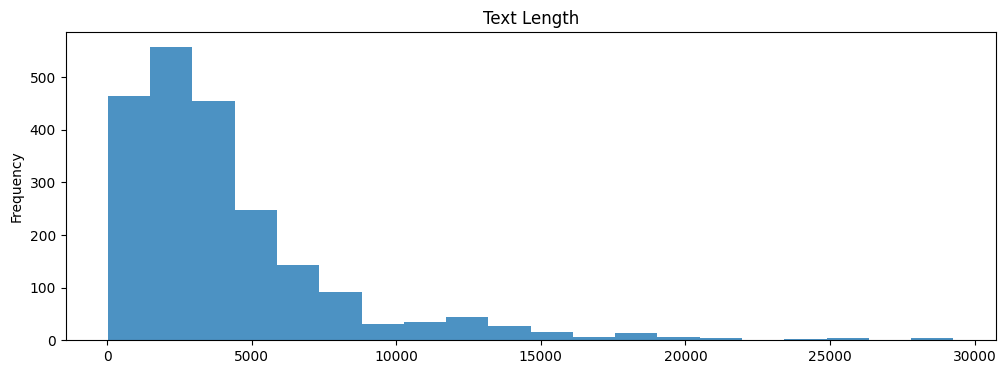

In [70]:
%matplotlib inline

plt.figure(figsize=(12, 4))

ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.40411961660769086


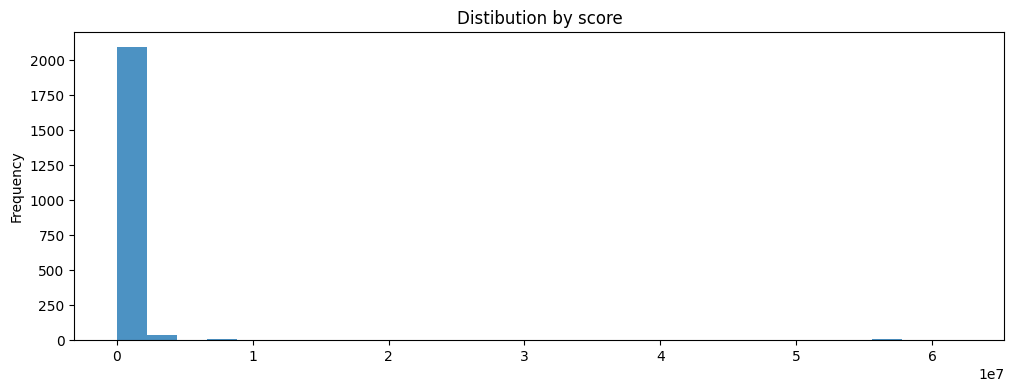

In [71]:
# score_column_name = 'score'
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 4))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [72]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5fca2ac99083b679224c77b0 RUB GeneralContract 39003.0
excluding 5fca2ac79083b679224c7750 RUB GeneralContract 41250.0
excluding 5fca2ac89083b679224c7786 RUB GeneralContract 43936.0
excluding 5fca2acd9083b679224c77da RUB GeneralContract 49045.0
excluding 5fca2ac79083b679224c774f RUB GeneralContract 39316.0
excluding 5f09a55a138e9184feef1f3d None Service 39869.0
excluding 5e5de70d01c6c73c19eebd4a None GeneralContract 31097.0
excluding 643535467e0e4e09d90ea3bc None GeneralContract 35881.0
excluding docs with rare subj
excluding 6166dbc387f1d9065bb8b937 nan AssetTransactions
excluding 5feb3e50bd24992aa31040df RUB AssetTransactions
excluding 5dee80604ddc27bcf92dd88e None EmployeeContracts


Service                              1098
Deal                                  251
Other                                 151
Loans                                 143
GeneralContract                       141
Renting                                83
AgencyContract                         63
Charity                                59
DealIntellectualProperty               47
Insurance                              33
BankGuarantees                         23
RealEstateTransactions                 19
RealEstate                             18
ParticipationInOtherOrganizations       8
PledgeEncumbrance                       7
SecuritiesTransactions                  6
Name: subject, dtype: int64


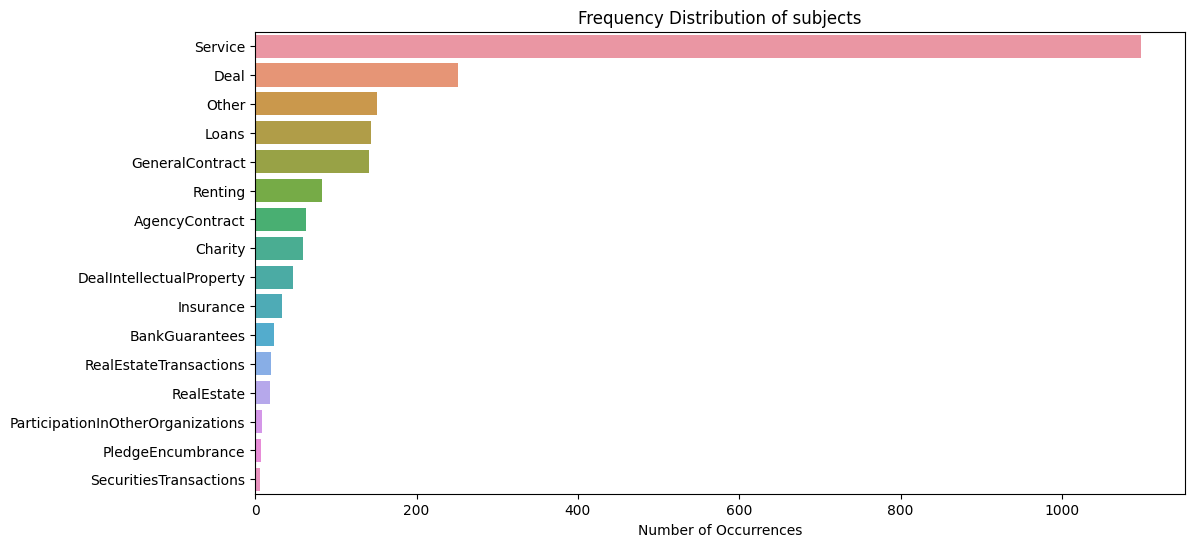

In [73]:
%matplotlib inline
try:
    cnt = dups_s['subject'].value_counts()

    plt.figure(figsize=(12, 6 ))
    sns.barplot(x=cnt.values, y=cnt.index)

    print(  cnt )

    plt.title('Frequency Distribution of subjects')
    plt.xlabel('Number of Occurrences')
    plt.show()
except:
    pass


In [74]:
dups_s.index.name = '_id'
_fn = Path(work_dir) / 'contract_trainset_meta.csv'
dups_s.to_csv(_fn, index=True)
mlflow.log_artifact(_fn)


_s = f"### {len(dups_s)} - Всего  документов в обучающем наборе на {lastdate:%d.%m.%Y}"
display(Markdown(_s))


dups_s

### 2150 - Всего  документов в обучающем наборе на 05.04.2023

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,dups,subset,url,unseen,score
_id,,,,,,,,,,,,,,,,,,,,,
634515c4172785f510f15e05,RUB,db,1e0b396c361ad164ee654ffb57a3b508,3.0.0,CONTRACT,2023-04-22 11:20:17.098872,2238.0,2022-10-11 10:07:14.195000+00:00,8.0,6.000000e+09,...,1.000000,60.0,2023-04-18 14:14:53.840000+00:00,True,99.0,1.0,CONTROL_EXCLUDED,http://gpn-audit.nemosoft.ru/#/audit/edit/6345...,False,1.675132
5ec2b8da665f7603e03b1271,RUB,db,96586b4a66ea7628cfd43b5358b48864,1.6.5,CONTRACT,2023-04-22 11:20:59.811603,5896.0,2020-05-21 16:50:23.737000+00:00,16.0,5.817000e+05,...,1.000000,50.0,2023-04-18 14:58:34.797000+00:00,True,1500.0,1.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,17.224739
5ec2b8da665f7603e03b1260,RUB,db,f7faba95b64e1f788304ae4e509533ee,1.6.5,CONTRACT,2023-04-22 11:20:59.709566,2353.0,2020-05-21 13:25:53.056000+00:00,13.0,1.365100e+04,...,1.000000,16.0,2023-04-18 14:53:25.280000+00:00,True,248.0,3.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,24.012270
638085a26a07f3e980b2c604,RUB,db,8c48205a1a42ec13cb573b091c0b9cc3,3.0.0,CONTRACT,2023-04-22 11:21:06.796776,4850.0,2022-11-25 12:33:56.624000+00:00,10.0,1.300000e+04,...,1.000000,96.0,2023-04-18 14:37:46.825000+00:00,True,112.0,3.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,108.064088
638085786a07f3e980b2c2b5,RUB,db,0dee81df1fe163f7c0189f46a7ebae8e,3.0.0,CONTRACT,2023-04-22 11:21:07.888579,4382.0,2022-11-25 18:37:01.373000+00:00,19.0,8.000000e+00,...,1.000000,37.0,2023-04-18 14:37:26.278000+00:00,True,138.0,2.0,CONTROL_TRAIN,http://gpn-audit.nemosoft.ru/#/audit/edit/6380...,False,700.452733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643535777e0e4e09d90ea7a4,RUB,db,93c1952f40184895afa0f1187495ee18,23.3.11,CONTRACT,2023-04-22 11:20:58.402404,16128.0,2023-04-16 00:49:29.544000+00:00,9.0,1.377100e+07,...,0.999047,36.0,NaT,True,255.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,1245.483385
643535787e0e4e09d90ea7a7,RUB,db,7c4d9538c17e37cd3f9ee420856d3318,23.3.11,CONTRACT,2023-04-22 11:20:58.776950,18950.0,2023-04-16 00:49:57.287000+00:00,43.0,5.000000e+08,...,0.980058,85.0,NaT,True,1972.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,595.007659
644139f3c083816b32b0c723,RUB,db,afa15c497df314886c1dd90ee2f1f499,23.3.11,CONTRACT,2023-04-22 11:20:59.024554,1412.0,2023-04-20 16:11:43.997000+00:00,12.0,5.550000e+08,...,0.979835,88.0,NaT,True,139.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6441...,True,344.705140


In [80]:
dups_s.iloc[dups_s.dups.argmax()]

currency                                                              RUB
source                                                                 db
checksum                                 03455452b993eb289683fa17c0b997fd
version                                                            23.3.1
documentType                                                    AGREEMENT
export_date                                    2023-04-20 17:07:43.829830
len                                                                  2869
analyze_date                             2023-03-01 16:34:32.570000+00:00
headers                                                                20
value                                                               1e+10
value_log1p                                                       23.0259
value_span                                                           1166
org-1-name                                                  Газпром нефть
org-1-alias                           

In [75]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [76]:
# dups_s[dups_s['unseen']]

,currency,source,checksum,version,documentType,export_date,len,analyze_date,headers,value,...,subject confidence,subj_len,user_correction_date,valid,subject_pos,dups,subset,url,unseen,score
_id,,,,,,,,,,,,,,,,,,,,,
5dece9bf4ddc27bcf92dd417,RUB,file,f929eb732496acc8342fd0af63385957,1.22.1,CONTRACT,2023-04-22 10:44:01.386858,1488.0,2020-06-30 19:24:06.620000+00:00,11.0,3.390000e+05,...,0.998039,86.0,NaT,True,NaN,2.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/5dec...,True,1607.801048
5ded07034ddc27bcf92dd4d5,RUB,file,6bd511518daf99e444810cdf79cfe3d5,1.12.0,CONTRACT,2023-04-22 10:44:01.767286,1733.0,2020-06-16 19:00:35.776000+00:00,16.0,3.000000e+04,...,0.999529,85.0,NaT,True,NaN,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,True,772.559225
5ded07184ddc27bcf92dd511,RUB,file,1a2ae018f124e8e341ef5d1e956a0b93,1.12.0,CONTRACT,2023-04-22 10:44:01.943078,3302.0,2020-06-16 19:04:57.301000+00:00,12.0,2.570000e+04,...,0.999585,35.0,NaT,True,NaN,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,True,17903.635667
5ded07184ddc27bcf92dd52c,RUB,file,345b4e94917c89e36ca1201177c7510d,1.12.0,CONTRACT,2023-04-22 10:44:01.974863,3493.0,2020-06-16 19:05:24.933000+00:00,12.0,9.492864e+05,...,0.977721,79.0,NaT,True,NaN,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,True,1487.514019
5ded07184ddc27bcf92dd531,RUB,file,db6e6cd7b9db54727dac7cdcebf91b2c,1.12.0,CONTRACT,2023-04-22 10:44:02.007485,2912.0,2020-06-16 19:05:59.570000+00:00,12.0,2.751260e+05,...,0.999691,35.0,NaT,True,NaN,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,True,4838.291290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643535777e0e4e09d90ea7a4,RUB,db,93c1952f40184895afa0f1187495ee18,23.3.11,CONTRACT,2023-04-22 11:20:58.402404,16128.0,2023-04-16 00:49:29.544000+00:00,9.0,1.377100e+07,...,0.999047,36.0,NaT,True,255.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,1245.483385
643535787e0e4e09d90ea7a7,RUB,db,7c4d9538c17e37cd3f9ee420856d3318,23.3.11,CONTRACT,2023-04-22 11:20:58.776950,18950.0,2023-04-16 00:49:57.287000+00:00,43.0,5.000000e+08,...,0.980058,85.0,NaT,True,1972.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6435...,True,595.007659
644139f3c083816b32b0c723,RUB,db,afa15c497df314886c1dd90ee2f1f499,23.3.11,CONTRACT,2023-04-22 11:20:59.024554,1412.0,2023-04-20 16:11:43.997000+00:00,12.0,5.550000e+08,...,0.979835,88.0,NaT,True,139.0,1.0,unknown,http://gpn-audit.nemosoft.ru/#/audit/edit/6441...,True,344.705140


In [81]:
%%time

       

query = {
  '$and': [
    q_contract_like,      
    q_human_done
  ]
}

db = get_mongodb_connection()
documents_collection = db[COLLECTION_NAME]
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])

_s = f"#### {len(res)} -- Всего документов, которые размечены биочеловеком 🤦"
display(Markdown(_s))


/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### 1223 -- Всего документов, которые размечены биочеловеком 🤦

CPU times: user 7.86 ms, sys: 0 ns, total: 7.86 ms
Wall time: 383 ms


# 🤦 Find markup errors

In [82]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1223


In [83]:
errors_report_file_prefix = "user_markup_errors"
errors_report_metric_prefix = "user"

user_docs_ids = user_docs_ids
%run -i -t {NOTEBOOKS_DIR}/validate_markup.ipynb
del user_docs_ids

DEBUG - 2023-04-22 11:43:01,124 - retrain_ipynb - --=logging started=--


Running on :platform.processor()='x86_64'
documents COLLECTION_NAME='documents'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 1223
CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 25.3 µs


#### 1557.0 -- всего ошибок/недочетов разметки в 1223 документах -- (1.2730989370400654 на документ)

<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/62496ab593ab4c8e926df71e14658bf2/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='62496ab593ab4c8e926df71e14658bf2', run_name='funny-squid-582', run_uuid='62496ab593ab4c8e926df71e14658bf2', start_time=1682152981139, status='RUNNING', user_id='root'>
see results at
http://192.168.10.38:5000/#/experiments/305219436181214624/runs/62496ab593ab4c8e926df71e14658bf2


In [ ]:

# auto_docs = validate_markup(auto_docs_ids)


# Statistics
### Collecting org types

## Validate auto markup

In [88]:
del userdocs
auto_docs_ids = dups_s[ (dups_s.user_correction_date.isnull()) & (dups_s.source=='db')  ].index
errors_report_file_prefix = "ai_markup_errors"
errors_report_metric_prefix = "ai"
user_docs_ids = auto_docs_ids
%run -i -t {NOTEBOOKS_DIR}/validate_markup.ipynb
del user_docs_ids

auto_docs = userdocs

DEBUG - 2023-04-22 11:46:18,294 - retrain_ipynb - --=logging started=--
DEBUG - 2023-04-22 11:46:18,294 - retrain_ipynb - --=logging started=--
DEBUG - 2023-04-22 11:46:18,294 - retrain_ipynb - --=logging started=--
/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


Running on :platform.processor()='x86_64'
documents COLLECTION_NAME='documents'
ml_flow_url='http://192.168.10.38:5000' set MLFLOW_URL env var to re-define
reports_path=PosixPath('/root/artem/analyser/training_reports') /root/artem/analyser/training_reports
['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']=
Number of contract IDs for validation (set ouside) is 763
CPU times: user 35 µs, sys: 1 µs, total: 36 µs
Wall time: 40.8 µs
--------------------------------------------------------------------------------
643534f67e0e4e09d90e9d72 сумма не та! sentence_

#### 1831.0 -- всего ошибок/недочетов разметки в 763 документах -- (2.399737876802097 на документ)

<RunInfo: artifact_uri='mlflow-artifacts:/305219436181214624/7d49bb899ec74fb48a5a1770f62974b5/artifacts', end_time=None, experiment_id='305219436181214624', lifecycle_stage='active', run_id='7d49bb899ec74fb48a5a1770f62974b5', run_name='judicious-stoat-533', run_uuid='7d49bb899ec74fb48a5a1770f62974b5', start_time=1682153178310, status='RUNNING', user_id='root'>
see results at
http://192.168.10.38:5000/#/experiments/305219436181214624/runs/7d49bb899ec74fb48a5a1770f62974b5


### Invalidate no-date docs

In [93]:
bad_docs = auto_docs[ (auto_docs['Дата'].isnull()) | (auto_docs['errors severity']>=10)]
bad_docs.index

for i, row in stats.iterrows():
    if i in bad_docs.index:
        dups_s.at[i, 'valid'] = False
# stats.loc[bad_docs.index].valid=False
dups_s.loc[bad_docs.index].valid
# for i, row in stats.iterrows():
#     if i

643535407e0e4e09d90ea326    False
6435351c7e0e4e09d90ea008    False
6435356b7e0e4e09d90ea6a9    False
6435353d7e0e4e09d90ea2e8    False
6435356b7e0e4e09d90ea6b0    False
                            ...  
6435351a7e0e4e09d90e9fd6    False
6435351b7e0e4e09d90e9fed    False
643535237e0e4e09d90ea096    False
643535247e0e4e09d90ea0a7    False
6435353f7e0e4e09d90ea30c    False
Name: valid, Length: 421, dtype: bool

In [94]:
good_docs = auto_docs[ (~auto_docs['Дата'].isnull()) & (auto_docs['errors severity']<10)]
good_docs
# auto_docs[auto_docs['errors count']<3]

,errors count,errors severity,дата редактирования,Дата,дата анализа,версия,filename,link,error,error missing,...,Date val.,Номер,сумма,сумма (старая),currency,сумма без налога,subject,налог,сумма с налогом,vat_unit
6435353e7e0e4e09d90ea2f1,6,9,None,17-05-2021,2023-04-12 12:24:54.303,23.3.11,Договора на оказание услуг_создание образовате...,https://gpn-audit.nemosoft.ru/#/audit/edit/643...,сумма с учетом налога не указана;\nНаименовани...,Номер отсутсвует;\nНаименование 2 отсутсвует;\...,...,2021-05-17,NaN,стоимость Услуг по настоящему Договору в разме...,________,рублей,NaN,NaN,NaN,NaN,NaN
63ce49fae83d1ee490f3f246,5,9,None,«25» апреля 2021,2023-01-23 14:51:37.328,23.01.23,"НКЗ, ООО/Соглашение о намерениях от 10.08.2017...",https://gpn-audit.nemosoft.ru/#/audit/edit/63c...,предмет договора слишком длинный: 179 слов;\n,сумма договора отсутсвует;\nНомер отсутсвует;\...,...,2021-04-25,NaN,NaN,NaN,NaN,NaN,"1.1. Рабочей группе, созданной согласно Проток...",NaN,NaN,NaN
5fdb2141542ce403c92b4572,4,9,None,18 декабря 2019,2020-12-17 14:03:56.850,2.0.5,19-68Д от 18.12ППО НОЯБЭС ТЮМНМО Всероссийский...,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,сумма с учетом налога не указана;\nНаименовани...,,...,2019-12-18,№ 19-68Д,"наименований 3, на сумму 13200 (Тринадцать тыс...",13200,рублей,NaN,NaN,NaN,NaN,NaN
5fdb2141542ce403c92b457a,4,9,None,18 декабря 2019,2020-12-17 14:05:52.312,2.0.5,19-68Д от 18 декабря Всерос.Электропрофсоюз.docx,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,сумма с учетом налога не указана;\nНаименовани...,,...,2019-12-18,№ 19-68Д,"наименований 3, на сумму 13200 (Тринадцать тыс...",13200,рублей,NaN,NaN,NaN,NaN,NaN
5fdb2141542ce403c92b456e,4,9,None,«30» апреля 2019,2020-12-17 13:59:17.419,2.0.5,19-11Р от 03.04.2019 АО Арктика Медиа распостр...,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Наименование 2 содержит кавычки;\nНаименование...,сумма договора отсутсвует;\n,...,2019-04-30,№ 19-18Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642bfefc31492115a02420d3,0,0,None,«30» июля 2018,2023-04-04 13:45:39.273,23.3.11,4. Договор_РП кп_неверный КО.docx,https://gpn-audit.nemosoft.ru/#/audit/edit/642...,,,...,2018-07-30,14552,"- 200000000 (двести миллионов) рублей, в том ч...",NaN,рублей,NaN,NaN,20,200000000,%
643535317e0e4e09d90ea1a3,0,0,None,«01» ноября 2022,2023-04-11 17:22:56.618,23.3.11,11. КД.docx,https://gpn-audit.nemosoft.ru/#/audit/edit/643...,,,...,2022-11-01,253,4.7. В течение срока действия настоящего Согла...,NaN,рублей,"10000000000,00",NaN,NaN,NaN,NaN
643534fa7e0e4e09d90e9dbc,0,0,None,«23» сентября 2022,2023-04-12 04:15:58.384,23.3.11,Договор Недра.docx,https://gpn-audit.nemosoft.ru/#/audit/edit/643...,,,...,2022-09-23,222,", общая сумма задолженности по которому в кажд...",NaN,рублей,60000000,NaN,NaN,NaN,NaN
643534fa7e0e4e09d90e9dbf,0,0,None,«05» апреля 2018,2023-04-12 04:16:34.896,23.3.11,договор.6_.docx,https://gpn-audit.nemosoft.ru/#/audit/edit/643...,,,...,2018-04-05,1,1.1. Стоимость участия Делегата в Мероприятии ...,NaN,рублей,10000,NaN,NaN,NaN,NaN


# Make datapoints

In [95]:
work_dir

PosixPath('/root/artem/work')

In [96]:

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init


In [ ]:
# _docs_ids = [str(i) for i in new_docs_ids]
# intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
# len(intersection_set)

In [ ]:
# good_docs.index

# intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 

### Trainset fixtures
#### Invalidate long subjects

In [97]:
%%time

ids = list(dups_s.index)


if not 'subject_pos' in stats:
    stats['subject_pos'] = None
        
ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_from_db_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len  
            
            stats.at[_id, 'subject_pos'] = span[0]
            dups_s.at[_id, 'subject_pos'] = span[0]  
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
# stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:14: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


CPU times: user 3.74 s, sys: 343 ms, total: 4.08 s
Wall time: 6.87 s


In [103]:
# dups_s

In [104]:
dups_s = dups_s[dups_s.valid==True]

In [105]:
dups_s.to_csv(export_fn, index=True)
mlflow.log_artifact(export_fn)

# Main sequence

In [106]:
%%time

from IPython.display import clear_output

# raise('test mode!')

# enumerate(list(intersection_set))
for k, oid in enumerate(dups_s.index): 
# for k, oid in enumerate(list(ids)):
    if k % 20 == 0:
        clear_output(wait=True)
        
# 
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_from_db_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(k, oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


5ec2b8d8665f7603e03b122d 500 of 2150 db
3069
embeddings saved to /root/artem/work/datasets/5ec2b8d8665f7603e03b122d-datapoint-embeddings.npy (3069, 1024)
5fc7a034c54bc33809e261a8 501 of 2150 db
4812
embeddings saved to /root/artem/work/datasets/5fc7a034c54bc33809e261a8-datapoint-embeddings.npy (4812, 1024)
5ebaa582665f7603e03b11ab 502 of 2150 db
562
embeddings saved to /root/artem/work/datasets/5ebaa582665f7603e03b11ab-datapoint-embeddings.npy (562, 1024)
5fbf75af5d05d73d0295fa99 503 of 2150 db
3265
embeddings saved to /root/artem/work/datasets/5fbf75af5d05d73d0295fa99-datapoint-embeddings.npy (3265, 1024)
62d149484ae369b4976e3203 504 of 2150 db
5351
embeddings saved to /root/artem/work/datasets/62d149484ae369b4976e3203-datapoint-embeddings.npy (5351, 1024)
5fb399dd39d5e82e9081847d 505 of 2150 db
3299
fixed number: ['№ СИУ'] -->  ['СИУ']
embeddings saved to /root/artem/work/datasets/5fb399dd39d5e82e9081847d-datapoint-embeddings.npy (3299, 1024)
63c92b5cfb21317f1d5e0f7c 506 of 2150 db
2

[legal_docs.py:610 -        embedd_tokens() ] embedding doc id=63a43aafbeaa9eeec65ecb22 chs=1e8a5b61dccd4ded711f96180ec11fe9
[embedder_elmo.py:51 - _build_session_and_graph() ] < loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
[embedder_elmo.py:52 - _build_session_and_graph() ] TF hub cache dir is  /root/artem/work/tf_cache
INFO:absl:Using /root/artem/work/tf_cache to cache modules.


embeddings saved to /root/artem/work/datasets/5ec2b8da665f7603e03b1275-datapoint-embeddings.npy (5261, 1024)
63a43aafbeaa9eeec65ecb22 517 of 2150 db
4893


[embedder_elmo.py:54 - _build_session_and_graph() ] ELMO module loaded >
INFO:gpn:ELMO module loaded >
[embedder_elmo.py:69 - _build_session_and_graph() ] ELMO: creating embedded_out_elmo...
INFO:gpn:ELMO: creating embedded_out_elmo...


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
[embedder_elmo.py:75 - _build_session_and_graph() ] ELMO: embedded_out_defaut embedded_out_elmo
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2023-04-22 12:11:30.337900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-04-22 12:11:30.387516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-22 12:11:30.388422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-04-22 12:11:30.388532: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-22 12:11:30.388732: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic libra

ResourceExhaustedError: SameWorkerRecvDone unable to allocate output tensor. Key: /job:localhost/replica:0/task:0/device:CPU:0;0000000000000001;/job:localhost/replica:0/task:0/device:GPU:0;edge_253_checkpoint_initializer_49;0:0
	 [[node checkpoint_initializer_49 (defined at /root/artem/env/lib/python3.8/site-packages/tensorflow_hub/native_module.py:458) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'checkpoint_initializer_49':
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/root/artem/env/lib/python3.8/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 711, in start
    self.io_loop.start()
  File "/root/artem/env/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
    await self.process_one()
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
    await dispatch(*args)
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
    await result
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
    reply_content = await reply_content
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
    res = shell.run_cell(
  File "/root/artem/env/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
    result = self._run_cell(
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
    return runner(coro)
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_837845/2452913330.py", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "\nfrom IPython.display import clear_output\n\n# raise('test mode!')\n\n# enumerate(list(intersection_set))\nfor k, oid in enumerate(dups_s.index): \n# for k, oid in enumerate(list(ids)):\n    if k % 20 == 0:\n        clear_output(wait=True)\n        \n# \n    iiid= ObjectId(oid)\n    src = dups_s.loc[oid]['source']\n    jd = None\n    if src == 'db':\n#       if False:\n        d = get_doc_from_db_by_id(iiid)\n        if d is not None:\n          jd = DbJsonDoc(d)\n    else:\n#         if False:\n        print(oid, k, 'of', len(ids), src)\n        jd = files_dict[iiid]\n        \n    print(oid, k, 'of', len(ids), src)\n\n    if jd is not None:\n        if jd.state in [15,12]:                \n            save_contract_data_arrays(jd)\n")
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2417, in run_cell_magic
    result = fn(*args, **kwargs)
  File "/root/artem/env/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1316, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 29, in <module>
  File "/root/artem/analyser/trainsets/retrain_contract_uber_model.py", line 70, in save_contract_data_arrays
    embeddings = embedd_tokens(tokens_map,
  File "/root/artem/analyser/analyser/legal_docs.py", line 616, in embedd_tokens
    embeddings = embedder.embedd_tokens(tokens_map_norm.tokens)
  File "/root/artem/analyser/tf_support/embedder_elmo.py", line 28, in embedd_tokens
    return self.instance.embedd_tokenized_text([tokens], [len(tokens)])[0]
  File "/root/artem/analyser/tf_support/embedder_elmo.py", line 97, in embedd_tokenized_text
    self._build_session_and_graph()  # lazy init
  File "/root/artem/analyser/tf_support/embedder_elmo.py", line 53, in _build_session_and_graph
    _elmo = hub.Module(self.module_url, trainable=False)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow_hub/module.py", line 176, in __init__
    self._impl = self._spec._create_impl(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow_hub/native_module.py", line 387, in _create_impl
    return _ModuleImpl(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow_hub/native_module.py", line 451, in __init__
    self._init_state(name)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow_hub/native_module.py", line 458, in _init_state
    tf.compat.v1.train.init_from_checkpoint(self._checkpoint_path,
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/training/checkpoint_utils.py", line 311, in init_from_checkpoint
    distribution_strategy_context.get_replica_context().merge_call(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3048, in merge_call
    return self._merge_call(merge_fn, args, kwargs)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py", line 3055, in _merge_call
    return merge_fn(self._strategy, *args, **kwargs)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py", line 597, in wrapper
    return func(*args, **kwargs)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/training/checkpoint_utils.py", line 306, in <lambda>
    init_from_checkpoint_fn = lambda _: _init_from_checkpoint(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/training/checkpoint_utils.py", line 356, in _init_from_checkpoint
    _set_variable_or_list_initializer(var, ckpt_file, tensor_name_in_ckpt)
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/training/checkpoint_utils.py", line 480, in _set_variable_or_list_initializer
    _set_checkpoint_initializer(variable_or_list, ckpt_file, tensor_name, "")
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/training/checkpoint_utils.py", line 433, in _set_checkpoint_initializer
    restore_op = io_ops.restore_v2(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1490, in restore_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 3557, in _create_op_internal
    ret = Operation(
  File "/root/artem/env/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 2045, in __init__
    self._traceback = tf_stack.extract_stack_for_node(self._c_op)


In [ ]:
print('see results at')
print(f'{mlflow.get_registry_uri()}/#/experiments/{mlflow.last_active_run().info.experiment_id}/runs/{mlflow.last_active_run().info.run_id}')